## JWST F560W LMC Flat Region

Data is setup in a subdirectory that is given in the filter variable below (i.e., "F560W"). Inside this directory, there should be 4 subdirectories called stage0, stage1, stage2, and stage3. The uncal (raw) fits files should be in the stage0 directory.

Author: Karl Gordon

Last modified: 5 Jul 2022

Based on JWebbinar notebooks by Bryan Hilbert, MIRI simulated notebooks by Mattia Libralato, input from various MIRI team members, and input from the jwst pipeline developers.

Uses custom code given in helpers subdirectory.

Extensively tested on MIRI ERO mosaics.

### Variables controling processing and display

In [1]:
filter = "F560W"
fwhm = 1.6
basename = "jw0104000100"

crval = None
rotation = None

# set to a specific rotation if desired
# rotation = 0.

# shifts determine from previous runs with treakreg or with other filters
#   analysis using Analyze_teakreg_shifts.ipynb
#   run this notebook after running shortest wavelength dataset with tweakreg=True and align_to_gaia=True
#     and setting all the tile?_shifts to [0.0, 0.0]
#   use the resulting shifts here and set tweakreg=False and align_to_gaia=False

# initial run
tile1_shifts = [0.0, 0.0]
tile2_shifts = [0.0, 0.0]
tile3_shifts = [0.0, 0.0]
tile4_shifts = [0.0, 0.0]
tile5_shifts = [0.0, 0.0]
tweakreg = True
align_to_gaia = True

# after analysis and for all other filters
# tile1_shifts = [0.10637643165419682, -0.11768223374643519]
# tile2_shifts = [0.10700657405766205, -0.13107961726782408]
# tile3_shifts = [0.10163923831678442, -0.12152158617752193]
# tile4_shifts = [0.09065352553736802, -0.12144904023219313]
# tile5_shifts = [-0.975754312382031, 1.0456499145482434]
# tweakreg = False
# align_to_gaia = False

# only needed if multiple datasets combined that are taken separately (e.g., weeks apart)
matchbkg = False

# display range for uncalibrated images
drange_raw = [3., 20.]
# display range for calibrated images
drange_cal = [1., 6.]
dmap = "afmhot"  # same as ds9 bb

# specify the linearity file to use if default not desired
linfile = None

# specify the flat file to use if default not desired
flatfile = None

# turn on/off the different stages of the pipeline
run_detector1 = False
run_image2 = True
run_image3 = True

In [2]:
import os
import glob
import copy

from astropy.io import ascii
from astropy.visualization import simple_norm

In [3]:
import astropy
print(astropy.__version__)

5.0.4


In [4]:
os.environ["CRDS_PATH"] = "/home/kgordon/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [6]:
# List of possible data quality flags
from jwst.datamodels import dqflags
from jwst import datamodels

from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

# custom helper routines
from helpers.jwst_helpers import show_image, overlay_catalog
from helpers.miri_helpers import miri_detector1, miri_image2, miri_image3
from helpers.miri_clean import fix_rateints_to_rate, shift_cal_wcs

In [7]:
import jwst
print(jwst.__version__)

1.5.4.dev17+geec8bb0d


In [8]:
import stcal
print(stcal.__version__)

1.0.1.dev1+g51f5dfc


## CALWEBB_DETECTOR1

In [9]:
miri_uncal_files = glob.glob(f"./{filter}/stage0/*uncal.fits")
output_dir = f'./{filter}/stage1'
print(miri_uncal_files)

['./F560W/stage0/jw01040001001_03101_00001_mirimage_uncal.fits', './F560W/stage0/jw01040001001_03101_00002_mirimage_uncal.fits', './F560W/stage0/jw01040001001_03101_00003_mirimage_uncal.fits', './F560W/stage0/jw01040001001_03101_00004_mirimage_uncal.fits', './F560W/stage0/jw01040001001_03101_00005_mirimage_uncal.fits', './F560W/stage0/jw01040001001_0310j_00001_mirimage_uncal.fits', './F560W/stage0/jw01040001001_0310j_00002_mirimage_uncal.fits', './F560W/stage0/jw01040001001_0310j_00003_mirimage_uncal.fits', './F560W/stage0/jw01040001001_0310j_00004_mirimage_uncal.fits', './F560W/stage0/jw01040001001_0310j_00005_mirimage_uncal.fits', './F560W/stage0/jw01040001002_03101_00001_mirimage_uncal.fits', './F560W/stage0/jw01040001002_03101_00002_mirimage_uncal.fits', './F560W/stage0/jw01040001002_03101_00003_mirimage_uncal.fits', './F560W/stage0/jw01040001002_03101_00004_mirimage_uncal.fits', './F560W/stage0/jw01040001002_03101_00005_mirimage_uncal.fits', './F560W/stage0/jw01040001002_0310j_000

In [10]:
if run_detector1:
    miri_detector1(miri_uncal_files, output_dir, linfile=linfile)

In [11]:
# fix the making of the rate images from the rateints images
#   needed for multiple integrations in regions near saturation
miri_rate_files = glob.glob(f"./{filter}/stage1/*ge_rate.fits")
for cfile in miri_rate_files:
    fix_rateints_to_rate(cfile)

In [12]:
# look at one of the images
miri_rate_files = glob.glob(f"./{filter}/stage1/*ge_fixed_rate.fits")
miri_rate = datamodels.open(miri_rate_files[0])
drange = drange_raw

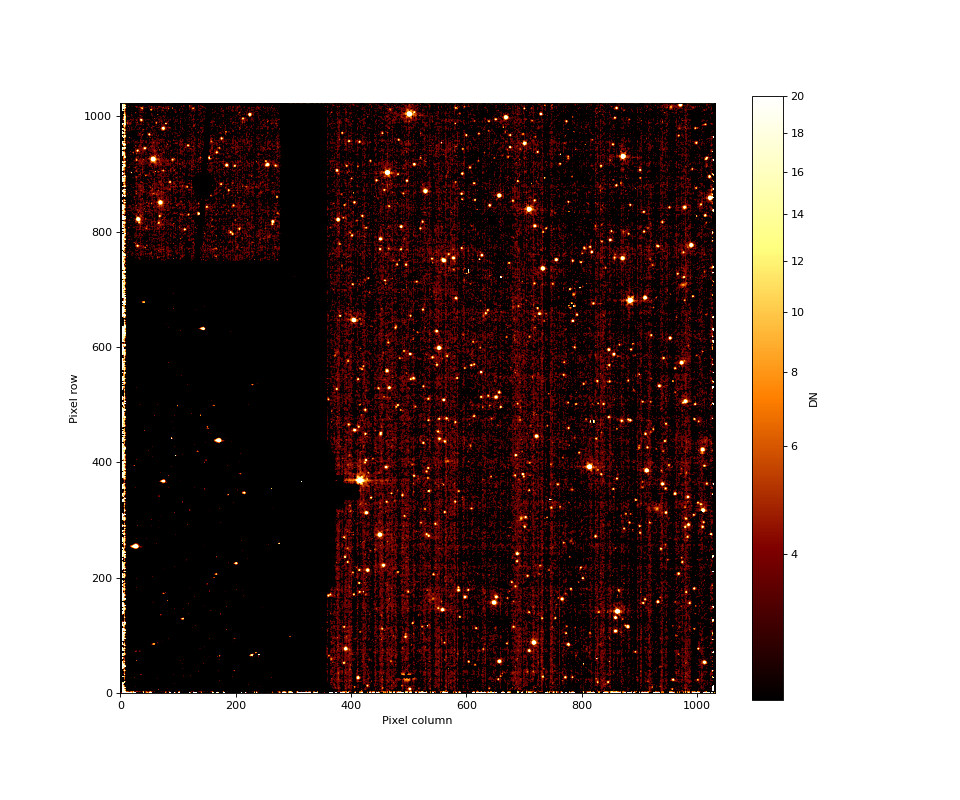

In [13]:
show_image(miri_rate.data, vmin=drange[0], vmax=drange[1], dmap=dmap)

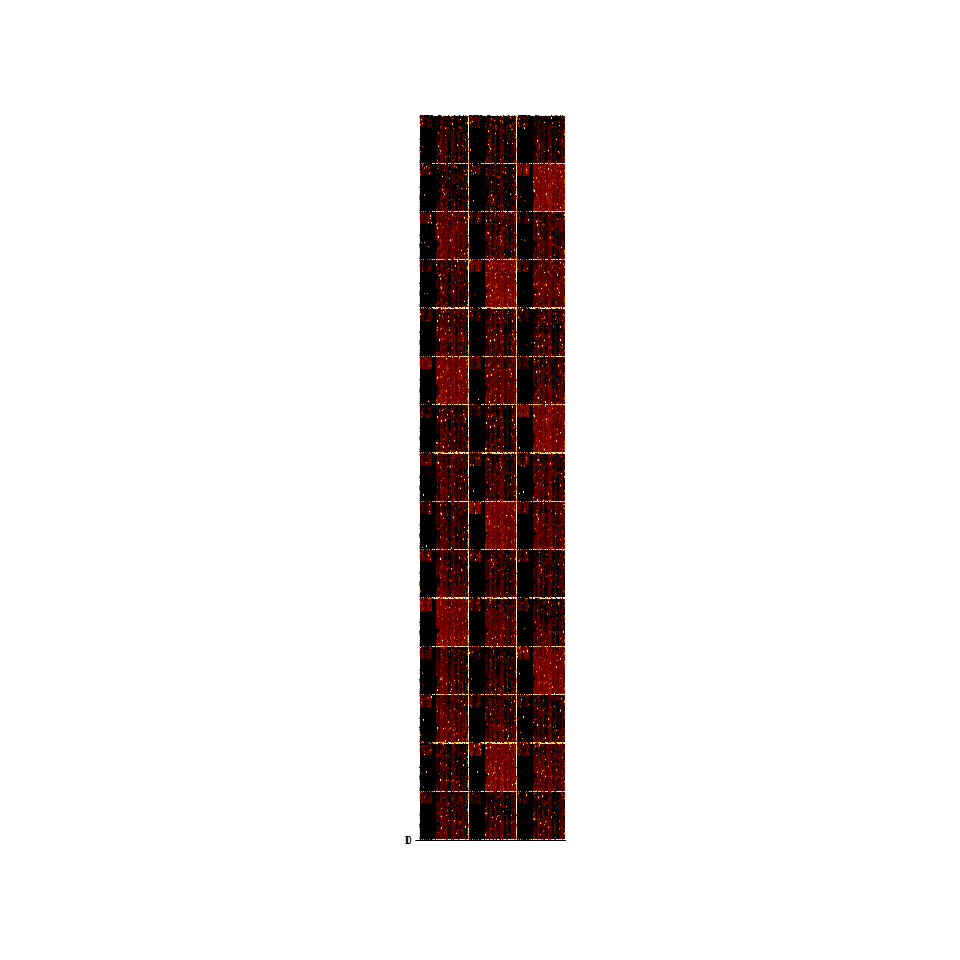

In [14]:
# display the images
fig = plt.figure(1, figsize=(12, 12))
ncols = len(miri_rate_files) // 3
grid = ImageGrid(fig, 111, nrows_ncols=(ncols+1, 3), axes_pad=0)

for i, cfile in enumerate(miri_rate_files):
    with datamodels.open(cfile) as miri_rate:
        cimage = miri_rate.data
        norm_data = simple_norm(cimage, "sqrt", min_cut=drange[0], max_cut=drange[1])
        grid[i].imshow(cimage, norm=norm_data, origin="lower", cmap=plt.get_cmap(dmap))
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])

## CALWEBB_IMAGE2

In [15]:
miri_rate_files = glob.glob(f"./{filter}/stage1/*ge_fixed_rate.fits")
output_dir = f'./{filter}/stage2'
print(miri_rate_files)

['./F560W/stage1/jw01040001001_03101_00001_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_03101_00002_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_03101_00003_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_03101_00004_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_03101_00005_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_0310j_00001_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_0310j_00002_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_0310j_00003_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_0310j_00004_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_0310j_00005_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001002_03101_00001_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001002_03101_00002_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001002_03101_00003_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001002_03101_00004_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001002_031

In [16]:
if run_image2:
    miri_image2(miri_rate_files, output_dir, flatfile=flatfile)

2022-07-15 09:29:29,407 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2022-07-15 09:29:29,409 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-07-15 09:29:29,413 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-07-15 09:29:29,416 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-07-15 09:29:29,419 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2022-07-15 09:29:29,423 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2022-07-15 09:29:29,755 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (['./F560W/stage1/jw01040001001_03101_00001_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_03101_00002_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_03101_00003_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_03101_00004_mirimage_fixed_rate.fits', './F560W/stage1/jw01040001001_03101_00005_mi

2022-07-15 09:29:34,451 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2022-07-15 09:29:34,453 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-07-15 09:29:34,454 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2022-07-15 09:29:34,454 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2022-07-15 09:29:34,455 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits'.
2022-07-15 09:29:34,457 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-07-15 09:29:34,458 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2022-07-15 09:29:34,459 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2022-07-15 09:29:34,461 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2022-

2022-07-15 09:29:34,549 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2022-07-15 09:29:34,550 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2022-07-15 09:29:34,551 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf'.
2022-07-15 09:29:34,553 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-15 09:29:34,554 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.
2022-07-15 09:29:34,555 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.
2022-07-15 09:29:34,555 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_flat_0

2022-07-15 09:29:34,638 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-07-15 09:29:34,639 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2022-07-15 09:29:34,639 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2022-07-15 09:29:34,640 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2022-07-15 09:29:34,640 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-07-15 09:29:34,642 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01040001001_0310j_00002_mirimage_fixed_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2022-07-15 09:29:34,651 - stpipe.Image2Pipeline - INFO - Prefetch fo

2022-07-15 09:29:34,725 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.
2022-07-15 09:29:34,726 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.
2022-07-15 09:29:34,727 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_flat_0787.fits'.
2022-07-15 09:29:34,727 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2022-07-15 09:29:34,728 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2022-07-15 09:29:34,728 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2022-07-15 09:29:34,730 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2022-07-15 09:29:34,730 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-07-15 09:29:34,731 - stpipe.Image2

2022-07-15 09:29:34,791 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01040001002_03101_00002_mirimage_fixed_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2022-07-15 09:29:34,797 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits'.
2022-07-15 09:29:34,800 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2022-07-15 09:29:34,800 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2022-07-15 09:29:34,801 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2022-07-15 09:29:34,801 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2022-07-

2022-07-15 09:29:34,856 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2022-07-15 09:29:34,857 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2022-07-15 09:29:34,857 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2022-07-15 09:29:34,858 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-07-15 09:29:34,858 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2022-07-15 09:29:34,859 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2022-07-15 09:29:34,860 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits'.
2022-07-15 09:29:34,862 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-07-15 09:29:34,862 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2022-07-15 09:29:

2022-07-15 09:29:34,927 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2022-07-15 09:29:34,928 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2022-07-15 09:29:34,928 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2022-07-15 09:29:34,929 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2022-07-15 09:29:34,929 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf'.
2022-07-15 09:29:34,931 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-15 09:29:34,931 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.
2022-07-15 09:29:34,932 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/kgordon/crds_cache/refe

2022-07-15 09:29:34,992 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2022-07-15 09:29:34,993 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits'.
2022-07-15 09:29:34,994 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-07-15 09:29:34,995 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2022-07-15 09:29:34,995 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2022-07-15 09:29:34,996 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2022-07-15 09:29:34,996 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-07-15 09:29:34,998 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01040001002_0310j_00005_mirimage_fixed_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disp

2022-07-15 09:29:35,059 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-15 09:29:35,059 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.
2022-07-15 09:29:35,060 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.
2022-07-15 09:29:35,061 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_flat_0787.fits'.
2022-07-15 09:29:35,062 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2022-07-15 09:29:35,062 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2022-07-15 09:29:35,063 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2022-07-15 09:29:35,063 - stpipe.Image2Pipeline - INFO - Prefetch for IF

2022-07-15 09:29:35,121 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2022-07-15 09:29:35,121 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-07-15 09:29:35,122 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01040001003_03101_00005_mirimage_fixed_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2022-07-15 09:29:35,131 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits'.
2022-07-15 09:29:35,134 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2022-07-15 09:29:35,135 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-07-15 09:29:35,196 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_flat_0787.fits'.
2022-07-15 09:29:35,196 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2022-07-15 09:29:35,197 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2022-07-15 09:29:35,197 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2022-07-15 09:29:35,198 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2022-07-15 09:29:35,198 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-07-15 09:29:35,199 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2022-07-15 09:29:35,199 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2022-07-15 09:29:35,201 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/kgordon/crds_cache/refe

2022-07-15 09:29:35,262 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits'.
2022-07-15 09:29:35,263 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2022-07-15 09:29:35,263 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2022-07-15 09:29:35,264 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2022-07-15 09:29:35,264 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2022-07-15 09:29:35,265 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf'.
2022-07-15 09:29:35,265 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-15 09:29:35,266 - stpipe.Image2Pipeline - INFO - Prefetch

2022-07-15 09:29:35,321 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2022-07-15 09:29:35,321 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2022-07-15 09:29:35,322 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits'.
2022-07-15 09:29:35,324 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-07-15 09:29:35,324 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2022-07-15 09:29:35,325 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2022-07-15 09:29:35,325 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2022-07-15 09:29:35,326 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-07-15 09:29:35,327 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw010400010

2022-07-15 09:29:35,388 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf'.
2022-07-15 09:29:35,391 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-15 09:29:35,392 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.
2022-07-15 09:29:35,392 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf'.
2022-07-15 09:29:35,394 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_flat_0787.fits'.
2022-07-15 09:29:35,395 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2022-07-15 09:29:35,396 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/

2022-07-15 09:29:35,457 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2022-07-15 09:29:35,458 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2022-07-15 09:29:35,458 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-07-15 09:29:35,459 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01040001004_0310j_00003_mirimage_fixed_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2022-07-15 09:29:35,467 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits'.
2022-07-15 09:29:35,468 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2022-07-15 09:29:35,522 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_flat_0787.fits'.
2022-07-15 09:29:35,522 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2022-07-15 09:29:35,523 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2022-07-15 09:29:35,523 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2022-07-15 09:29:35,524 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2022-07-15 09:29:35,524 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-07-15 09:29:35,525 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2022-07-15 09:29:35,525 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2022-07-15 09:29:35,526 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/kgordon/crds_cache/refe

2022-07-15 09:29:35,609 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits'.
2022-07-15 09:29:35,611 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2022-07-15 09:29:35,611 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2022-07-15 09:29:35,612 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2022-07-15 09:29:35,613 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2022-07-15 09:29:35,613 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf'.
2022-07-15 09:29:35,615 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-15 09:29:35,616 - stpipe.Image2Pipeline - INFO - Prefetch

2022-07-15 09:29:35,677 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2022-07-15 09:29:35,677 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2022-07-15 09:29:35,678 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits'.
2022-07-15 09:29:35,681 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-07-15 09:29:35,682 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2022-07-15 09:29:35,683 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2022-07-15 09:29:35,684 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2022-07-15 09:29:35,684 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-07-15 09:29:35,688 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...
2022-07-15 09:29:35,703 -

2022-07-15 09:29:44,667 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2022-07-15 09:29:44,668 - stpipe.Image2Pipeline - INFO - Finished processing product ./F560W/stage1/jw01040001001_03101_00001_mirimage_fixed
2022-07-15 09:29:44,671 - stpipe.Image2Pipeline - INFO - Processing product ./F560W/stage1/jw01040001001_03101_00002_mirimage_fixed
2022-07-15 09:29:44,672 - stpipe.Image2Pipeline - INFO - Working on input ./F560W/stage1/jw01040001001_03101_00002_mirimage_fixed_rate.fits ...
2022-07-15 09:29:45,134 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from jw01040001001_03101_00002_mirimage_fixed_rate.fits>,).
2022-07-15 09:29:45,138 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wc

2022-07-15 09:29:54,143 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-07-15 09:29:54,548 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa'

2022-07-15 09:30:03,463 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.563052283 -69.457136914 80.581953537 -69.487707540 80.669568926 -69.481065758 80.651325834 -69.450393351
2022-07-15 09:30:03,464 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.563052283 -69.457136914 80.581953537 -69.487707540 80.669568926 -69.481065758 80.651325834 -69.450393351
2022-07-15 09:30:03,465 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-07-15 09:30:03,606 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-07-15 09:30:03,961 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from jw01040001001_03101_00004_mirimage_fixed_rate.fits>,).
2022-07-15 09:30:03,965 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'outp

2022-07-15 09:30:13,051 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-07-15 09:30:13,276 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:30:13,277 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:30:13,278 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:30:13,290 - stpipe.Image2Pipeline.flat_field - WARNING - K

2022-07-15 09:30:22,515 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:30:22,529 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:30:22,763 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-07-15 09:30:23,127 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw01040001001_0310j_00001_mirimage_fixed_rate.fits>,).
2022-07-15 09:30:23,131 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-07-15 09:30:23

2022-07-15 09:30:32,169 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits
2022-07-15 09:30:32,171 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-07-15 09:30:32,328 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2022-07-15 09:30:32,329 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2022-07-15 09:30:32,330 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2022-07-15 09:30:32,331 - stpipe.Image2Pipeline.photom - INFO -  filter: F560W
2022-07-15 09:30:32,423 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2022-07-15 09:30:32,427 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2022-07-15 09:30:32,428 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.
2022-07-15 09:30:32,429 - stpipe.Image2P

2022-07-15 09:30:41,407 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2022-07-15 09:30:41,408 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.
2022-07-15 09:30:41,409 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.579354
2022-07-15 09:30:41,446 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-07-15 09:30:41,780 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from jw01040001001_0310j_00003_mirimage_fixed_rate.fits>,).
2022-07-15 09:30:41,785 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None,

2022-07-15 09:30:50,931 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits
2022-07-15 09:30:51,224 - stpipe.Image2Pipeline.resample - INFO - Resampling science data
2022-07-15 09:30:51,853 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:30:52,539 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise
2022-07-15 09:30:53,166 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:30:53,815 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson
2022-07-15 09:30:54,433 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:30:55,092 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-07-15 09:30:55,726 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:30:56,460 - stpipe.Image2Pipeline.resample 

2022-07-15 09:31:04,280 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-07-15 09:31:04,925 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:31:05,641 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.546289714 -69.462025446 80.564948103 -69.492732149 80.653429796 -69.486099601 80.634650641 -69.455402384
2022-07-15 09:31:05,900 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./F560W/stage2/jw01040001001_0310j_00005_mirimage_fixed_i2d.fits
2022-07-15 09:31:05,901 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2022-07-15 09:31:05,902 - stpipe.Image2Pipeline - INFO - Finished processing product ./F560W/stage1/jw01040001001_0310j_00005_mirimage_fixed
2022-07-15 09:31:05,905 - stpipe.Image2Pipeline - INFO - Processing product ./F560W/stage1/jw01040001002_03101_00001_mirimage_fixed
2022-07-15 09:31:05,906 - stpipe.Image2Pipeline - INFO - Working on input ./F560W/stage1/jw010400

2022-07-15 09:31:15,300 - stpipe.Image2Pipeline - INFO - Processing product ./F560W/stage1/jw01040001002_03101_00002_mirimage_fixed
2022-07-15 09:31:15,301 - stpipe.Image2Pipeline - INFO - Working on input ./F560W/stage1/jw01040001002_03101_00002_mirimage_fixed_rate.fits ...
2022-07-15 09:31:15,713 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from jw01040001002_03101_00002_mirimage_fixed_rate.fits>,).
2022-07-15 09:31:15,718 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 

2022-07-15 09:31:25,471 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}
2022-07-15 09:31:25,633 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.528958452 -69.458964460 80.547813137 -69.489538744 80.635446511 -69.482913937 80.617250147 -69.452238001
2022-07-15 09:31:25,635 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.528958452 -69.458964460 80.547813137 -69.489538744 80.635446511 -69.482913937 80.617250147 -69.452238001
2022-07-15 09:31:25,636 - stpipe.Image2

2022-07-15 09:31:35,128 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.525178707 -69.459886363 80.544028971 -69.490461044 80.631667253 -69.483838078 80.613475345 -69.453161760
2022-07-15 09:31:35,129 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-07-15 09:31:35,273 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-07-15 09:31:35,608 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from jw01040001002_03101_00004_mirimage_fixed_rate.fits>,).
2022-07-15 09:31:35,611 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat':

2022-07-15 09:31:45,515 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:31:45,516 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:31:45,518 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:31:45,533 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:31:45,796 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-07-15 09:31:46,126 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw01040001002_03101_00005_mirimage_fixed_rate.fits>,).
2022-07-15 09:31:46,129 - stpipe.Image2Pipeline.photom - INFO - Step photom paramete

2022-07-15 09:31:54,985 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw01040001002_0310j_00001_mirimage_fixed_rate.fits>,).
2022-07-15 09:31:54,990 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-07-15 09:31:55,057 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits
2022-07-15 09:31:55,058 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-07-15 09:31:55,212 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2022-07-15 09:31:55

2022-07-15 09:32:04,163 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-07-15 09:32:04,354 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2022-07-15 09:32:04,356 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2022-07-15 09:32:04,356 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2022-07-15 09:32:04,357 - stpipe.Image2Pipeline.photom - INFO -  filter: F560W
2022-07-15 09:32:04,452 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2022-07-15 09:32:04,457 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2022-07-15 09:32:04,458 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.
2022-07-15 09:32:04,460 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.579354
2022-07-15 09:32:04,500 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-07-15 09:32:04,835 - stpipe.Ima

2022-07-15 09:32:14,166 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.579354
2022-07-15 09:32:14,218 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-07-15 09:32:14,570 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from jw01040001002_0310j_00003_mirimage_fixed_rate.fits>,).
2022-07-15 09:32:14,574 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': False, 'allowed_memory': None}
2022-07-15 09:32:14,675 - stpipe.Image2P

2022-07-15 09:32:24,530 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits
2022-07-15 09:32:24,862 - stpipe.Image2Pipeline.resample - INFO - Resampling science data
2022-07-15 09:32:25,539 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:32:26,286 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise
2022-07-15 09:32:26,975 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:32:27,619 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson
2022-07-15 09:32:28,342 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:32:29,041 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-07-15 09:32:29,696 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:32:30,516 - stpipe.Image2Pipeline.resample 

2022-07-15 09:32:38,937 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-07-15 09:32:39,635 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:32:40,608 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.521443866 -69.453371424 80.540059899 -69.484080727 80.628513452 -69.477460532 80.609776713 -69.446760694
2022-07-15 09:32:40,929 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./F560W/stage2/jw01040001002_0310j_00005_mirimage_fixed_i2d.fits
2022-07-15 09:32:40,933 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2022-07-15 09:32:40,938 - stpipe.Image2Pipeline - INFO - Finished processing product ./F560W/stage1/jw01040001002_0310j_00005_mirimage_fixed
2022-07-15 09:32:40,945 - stpipe.Image2Pipeline - INFO - Processing product ./F560W/stage1/jw01040001003_03101_00001_mirimage_fixed
2022-07-15 09:32:40,949 - stpipe.Image2Pipeline - INFO - Working on input ./F560W/stage1/jw010400

2022-07-15 09:32:51,702 - stpipe.Image2Pipeline - INFO - Processing product ./F560W/stage1/jw01040001003_03101_00002_mirimage_fixed
2022-07-15 09:32:51,703 - stpipe.Image2Pipeline - INFO - Working on input ./F560W/stage1/jw01040001003_03101_00002_mirimage_fixed_rate.fits ...
2022-07-15 09:32:52,149 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from jw01040001003_03101_00002_mirimage_fixed_rate.fits>,).
2022-07-15 09:32:52,153 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 

2022-07-15 09:33:02,872 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}
2022-07-15 09:33:03,014 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.541980138 -69.447562989 80.560843922 -69.478135822 80.648426555 -69.471504292 80.630220769 -69.440829750
2022-07-15 09:33:03,015 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.541980138 -69.447562989 80.560843922 -69.478135822 80.648426555 -69.471504292 80.630220769 -69.440829750
2022-07-15 09:33:03,016 - stpipe.Image2

2022-07-15 09:33:12,221 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.538207395 -69.448485996 80.557066343 -69.479059258 80.644653976 -69.472429717 80.626453062 -69.441754762
2022-07-15 09:33:12,221 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-07-15 09:33:12,417 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-07-15 09:33:12,765 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from jw01040001003_03101_00004_mirimage_fixed_rate.fits>,).
2022-07-15 09:33:12,768 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat':

2022-07-15 09:33:21,620 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:33:21,621 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:33:21,622 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:33:21,635 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:33:21,863 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-07-15 09:33:22,181 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw01040001003_03101_00005_mirimage_fixed_rate.fits>,).
2022-07-15 09:33:22,184 - stpipe.Image2Pipeline.photom - INFO - Step photom paramete

2022-07-15 09:33:31,588 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw01040001003_0310j_00001_mirimage_fixed_rate.fits>,).
2022-07-15 09:33:31,591 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-07-15 09:33:31,651 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits
2022-07-15 09:33:31,653 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-07-15 09:33:31,848 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2022-07-15 09:33:31

2022-07-15 09:33:42,378 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-07-15 09:33:42,555 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2022-07-15 09:33:42,556 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2022-07-15 09:33:42,557 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2022-07-15 09:33:42,558 - stpipe.Image2Pipeline.photom - INFO -  filter: F560W
2022-07-15 09:33:42,691 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2022-07-15 09:33:42,703 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2022-07-15 09:33:42,708 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.
2022-07-15 09:33:42,713 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.579354
2022-07-15 09:33:42,753 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-07-15 09:33:43,143 - stpipe.Ima

2022-07-15 09:33:53,786 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.579354
2022-07-15 09:33:53,818 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-07-15 09:33:54,219 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from jw01040001003_0310j_00003_mirimage_fixed_rate.fits>,).
2022-07-15 09:33:54,223 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': False, 'allowed_memory': None}
2022-07-15 09:33:54,278 - stpipe.Image2P

2022-07-15 09:34:05,714 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits
2022-07-15 09:34:06,049 - stpipe.Image2Pipeline.resample - INFO - Resampling science data
2022-07-15 09:34:06,846 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:34:07,624 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise
2022-07-15 09:34:08,339 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:34:09,087 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson
2022-07-15 09:34:09,812 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:34:10,593 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-07-15 09:34:11,350 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:34:12,152 - stpipe.Image2Pipeline.resample 

2022-07-15 09:34:20,301 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-07-15 09:34:21,030 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:34:21,773 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.559307190 -69.450620885 80.577975706 -69.481326089 80.666405997 -69.474686455 80.647616876 -69.443990741
2022-07-15 09:34:22,024 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./F560W/stage2/jw01040001003_0310j_00005_mirimage_fixed_i2d.fits
2022-07-15 09:34:22,025 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2022-07-15 09:34:22,026 - stpipe.Image2Pipeline - INFO - Finished processing product ./F560W/stage1/jw01040001003_0310j_00005_mirimage_fixed
2022-07-15 09:34:22,029 - stpipe.Image2Pipeline - INFO - Processing product ./F560W/stage1/jw01040001004_03101_00001_mirimage_fixed
2022-07-15 09:34:22,029 - stpipe.Image2Pipeline - INFO - Working on input ./F560W/stage1/jw010400

2022-07-15 09:34:31,551 - stpipe.Image2Pipeline - INFO - Processing product ./F560W/stage1/jw01040001004_03101_00002_mirimage_fixed
2022-07-15 09:34:31,553 - stpipe.Image2Pipeline - INFO - Working on input ./F560W/stage1/jw01040001004_03101_00002_mirimage_fixed_rate.fits ...
2022-07-15 09:34:32,050 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from jw01040001004_03101_00002_mirimage_fixed_rate.fits>,).
2022-07-15 09:34:32,054 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 

2022-07-15 09:34:43,025 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}
2022-07-15 09:34:43,169 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.554991877 -69.436162035 80.573863797 -69.466733487 80.661395953 -69.460095571 80.643181710 -69.429422356
2022-07-15 09:34:43,170 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.554991877 -69.436162035 80.573863797 -69.466733487 80.661395953 -69.460095571 80.643181710 -69.429422356
2022-07-15 09:34:43,171 - stpipe.Image2

2022-07-15 09:34:53,477 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.551218247 -69.437084628 80.570085571 -69.467656492 80.657622669 -69.461020481 80.639413058 -69.430346870
2022-07-15 09:34:53,478 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-07-15 09:34:53,641 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-07-15 09:34:54,129 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from jw01040001004_03101_00004_mirimage_fixed_rate.fits>,).
2022-07-15 09:34:54,138 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat':

2022-07-15 09:35:05,039 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:35:05,040 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:35:05,041 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:35:05,053 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:35:05,280 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-07-15 09:35:05,734 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw01040001004_03101_00005_mirimage_fixed_rate.fits>,).
2022-07-15 09:35:05,737 - stpipe.Image2Pipeline.photom - INFO - Step photom paramete

2022-07-15 09:35:16,078 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw01040001004_0310j_00001_mirimage_fixed_rate.fits>,).
2022-07-15 09:35:16,082 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-07-15 09:35:16,159 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0074.fits
2022-07-15 09:35:16,160 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-07-15 09:35:16,338 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2022-07-15 09:35:16

2022-07-15 09:35:26,504 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-07-15 09:35:26,673 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2022-07-15 09:35:26,674 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2022-07-15 09:35:26,675 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2022-07-15 09:35:26,676 - stpipe.Image2Pipeline.photom - INFO -  filter: F560W
2022-07-15 09:35:26,834 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2022-07-15 09:35:26,840 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2022-07-15 09:35:26,842 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.
2022-07-15 09:35:26,843 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.579354
2022-07-15 09:35:26,916 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-07-15 09:35:27,341 - stpipe.Ima

2022-07-15 09:35:37,541 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.579354
2022-07-15 09:35:37,576 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-07-15 09:35:38,004 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from jw01040001004_0310j_00003_mirimage_fixed_rate.fits>,).
2022-07-15 09:35:38,008 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': False, 'allowed_memory': None}
2022-07-15 09:35:38,065 - stpipe.Image2P

2022-07-15 09:35:48,192 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits
2022-07-15 09:35:48,555 - stpipe.Image2Pipeline.resample - INFO - Resampling science data
2022-07-15 09:35:49,294 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:35:50,076 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise
2022-07-15 09:35:50,830 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:35:51,584 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson
2022-07-15 09:35:52,298 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:35:53,007 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-07-15 09:35:53,766 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:35:54,472 - stpipe.Image2Pipeline.resample 

2022-07-15 09:36:03,655 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-07-15 09:36:04,455 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2022-07-15 09:36:05,126 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.534468282 -69.441971095 80.553093385 -69.472678983 80.641495835 -69.466052085 80.622750187 -69.435353666
2022-07-15 09:36:05,532 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./F560W/stage2/jw01040001004_0310j_00005_mirimage_fixed_i2d.fits
2022-07-15 09:36:05,533 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2022-07-15 09:36:05,534 - stpipe.Image2Pipeline - INFO - Finished processing product ./F560W/stage1/jw01040001004_0310j_00005_mirimage_fixed
2022-07-15 09:36:05,537 - stpipe.Image2Pipeline - INFO - Processing product ./F560W/stage1/jw01040001005_03101_00001_mirimage_fixed
2022-07-15 09:36:05,538 - stpipe.Image2Pipeline - INFO - Working on input ./F560W/stage1/jw010400

2022-07-15 09:36:16,075 - stpipe.Image2Pipeline - INFO - Processing product ./F560W/stage1/jw01040001005_03101_00002_mirimage_fixed
2022-07-15 09:36:16,076 - stpipe.Image2Pipeline - INFO - Working on input ./F560W/stage1/jw01040001005_03101_00002_mirimage_fixed_rate.fits ...
2022-07-15 09:36:16,662 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from jw01040001005_03101_00002_mirimage_fixed_rate.fits>,).
2022-07-15 09:36:16,666 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 

2022-07-15 09:36:28,126 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0006.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}
2022-07-15 09:36:28,371 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.517154766 -69.438910111 80.535975579 -69.469485628 80.623530615 -69.462866585 80.605367675 -69.432189449
2022-07-15 09:36:28,373 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.517154766 -69.438910111 80.535975579 -69.469485628 80.623530615 -69.462866585 80.605367675 -69.432189449
2022-07-15 09:36:28,374 - stpipe.Image2

2022-07-15 09:36:39,736 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.513378775 -69.439830917 80.532195341 -69.470406817 80.619755233 -69.463789556 80.601596575 -69.433112050
2022-07-15 09:36:39,737 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-07-15 09:36:39,905 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-07-15 09:36:40,313 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from jw01040001005_03101_00004_mirimage_fixed_rate.fits>,).
2022-07-15 09:36:40,317 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat':

2022-07-15 09:36:51,715 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:36:51,717 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:36:51,718 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:36:51,731 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2022-07-15 09:36:51,967 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-07-15 09:36:52,371 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from jw01040001005_03101_00005_mirimage_fixed_rate.fits>,).
2022-07-15 09:36:52,374 - stpipe.Image2Pipeline.photom - INFO - Step photom paramete

2022-07-15 09:37:00,368 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0927.pmap
2022-07-15 09:37:00,369 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0927.pmap
2022-07-15 09:37:00,370 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0927.pmap
2022-07-15 09:37:00,371 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0927.pmap
2022-07-15 09:37:00,372 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0927.pmap
2022-07-15 09:37:00,373 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0927.pmap
2022-07-15 09:37:00,374 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0927.pmap
2022-07-15 09:37:00,375 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0927.pmap
2022-07-15 09:37:00,376 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0927.pmap
2022-07-15 09:37:00,377 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0927.pmap
2022-07-15

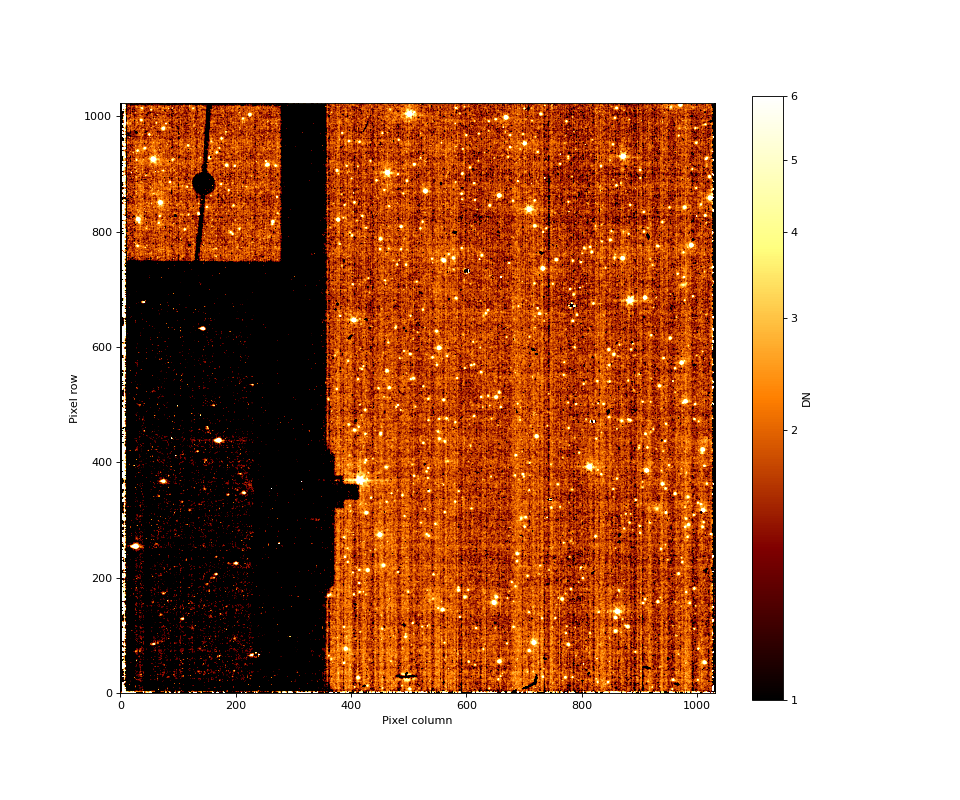

In [17]:
drange = drange_cal
# look at one of the images
miri_cal_files = glob.glob(f"./{filter}/stage2/*ge_fixed_cal.fits")
miri_cal = datamodels.open(miri_cal_files[0])
show_image(miri_cal.data, vmin=drange[0], vmax=drange[1], dmap=dmap)

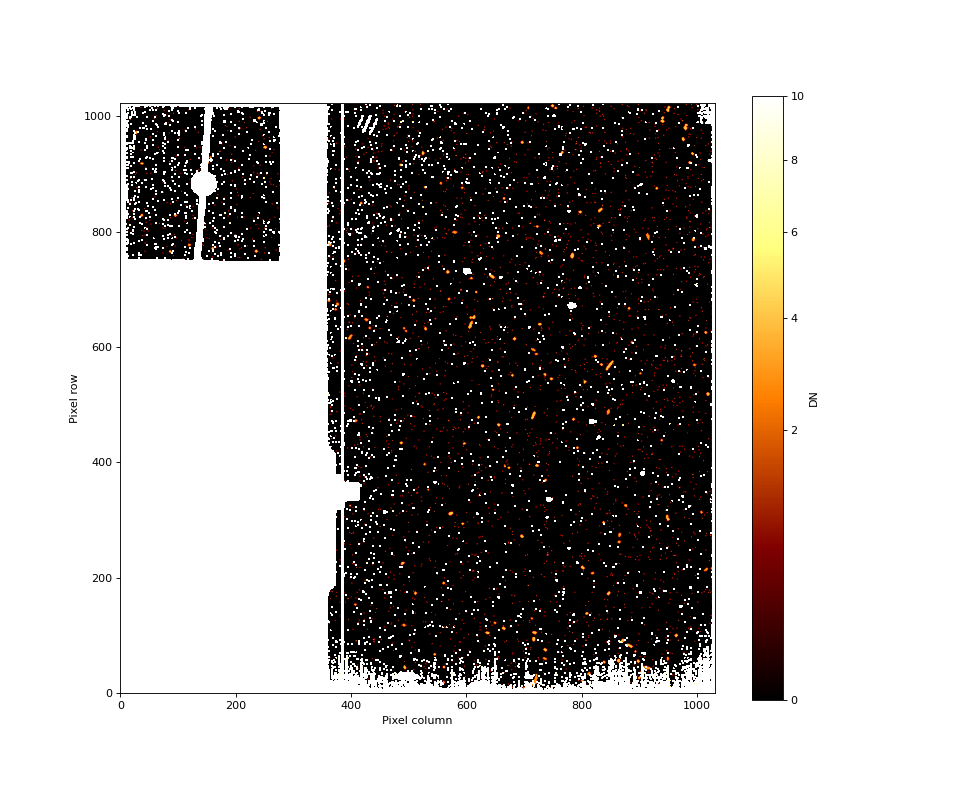

In [18]:
show_image(miri_cal.dq, 0, 10, dmap=dmap)

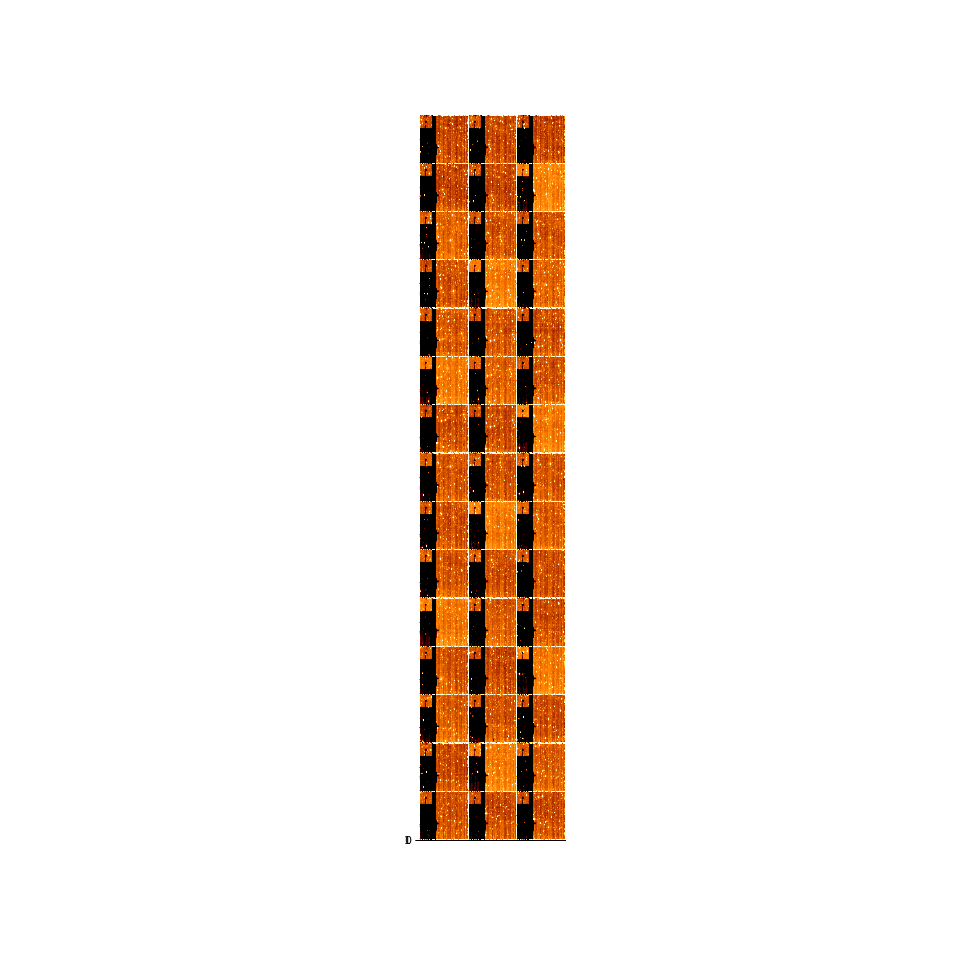

In [19]:
# display the images
fig = plt.figure(1, figsize=(12, 12))
ncols = len(miri_cal_files) // 3
grid = ImageGrid(fig, 111, nrows_ncols=(ncols+1, 3), axes_pad=0)

for i, cfile in enumerate(miri_cal_files):
    with datamodels.open(cfile) as miri_cal:
        cimage = miri_cal.data
        norm_data = simple_norm(cimage, "sqrt", min_cut=drange[0], max_cut=drange[1])
        grid[i].imshow(cimage, norm=norm_data, origin="lower", cmap=plt.get_cmap(dmap))
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])

## CALWEBB_IMAGE3

In [20]:
# update the WCS for mosaic tile 1
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}1*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile1_shifts)

# update the WCS for mosaic tile 2
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}2*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile2_shifts)
    
# update the WCS for mosaic tile 3
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}3*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile3_shifts)
    
# update the WCS for mosaic tile 4
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}4*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile4_shifts)
    
# update the WCS for mosaic tile 5
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}5*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile5_shifts)

In [21]:
miri_cal_files = glob.glob(f"./{filter}/stage2/j*ge_fixed_wcs_cal.fits")
output_dir = f"./{filter}/stage3/"
print(miri_cal_files)

if rotation is not None:
    miri_asn_name = f'miri_{filter}_stage3_fixedrot_asn'
else: 
    miri_asn_name = f'miri_{filter}_stage3_asn'
miri_asn = asn_from_list.asn_from_list(miri_cal_files, rule=DMS_Level3_Base, product_name=miri_asn_name)

miri_asn_file = f'{miri_asn_name}.json'
with open(miri_asn_file, 'w') as outfile:
    name, serialized = miri_asn.dump(format='json')
    outfile.write(serialized)
    
print(miri_asn_file)

['./F560W/stage2/jw01040001001_03101_00001_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001001_03101_00002_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001001_03101_00003_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001001_03101_00004_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001001_03101_00005_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001001_0310j_00001_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001001_0310j_00002_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001001_0310j_00003_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001001_0310j_00004_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001001_0310j_00005_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001002_03101_00001_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001002_03101_00002_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001002_03101_00003_mirimage_fixed_wcs_cal.fits', './F560W/stage2/jw01040001002_03101_00004_mirimage_fixed_wcs_ca

In [ ]:
if run_image3:
    miri_image3(miri_asn_file, output_dir, fwhm=fwhm, matchbkg=matchbkg, 
                crval=crval, rotation=rotation, 
                tweakreg=tweakreg, align_to_gaia=align_to_gaia)

2022-07-15 09:38:30,971 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-07-15 09:38:30,975 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-07-15 09:38:30,982 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2022-07-15 09:38:30,995 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2022-07-15 09:38:31,005 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-07-15 09:38:31,011 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2022-07-15 09:38:31,017 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2022-07-15 09:38:31,594 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('miri_F560W_stage3_asn.json',).
2022-07-15 09:38:31,613 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '

2022-07-15 09:39:01,885 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in jw01040001002_0310j_00002_mirimage_fixed_wcs_cal.fits.
2022-07-15 09:39:02,540 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in jw01040001002_0310j_00003_mirimage_fixed_wcs_cal.fits.
2022-07-15 09:39:03,257 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in jw01040001002_0310j_00004_mirimage_fixed_wcs_cal.fits.
2022-07-15 09:39:03,964 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in jw01040001002_0310j_00005_mirimage_fixed_wcs_cal.fits.
2022-07-15 09:39:04,697 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in jw01040001003_03101_00001_mirimage_fixed_wcs_cal.fits.
2022-07-15 09:39:05,416 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in jw01040001003_03101_00002_mirimage_fixed_wcs_cal.fits.
2022-07-15 09:39:06,135 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in jw01040001003_03101_00003_mirimage_fixed

2022-07-15 09:39:23,414 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw01040001002_0310j_00001_mirimage_fixed_wcs_cal':
2022-07-15 09:39:23,416 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01040001002_0310j_00001_mirimage_fixed_wcs_cal
2022-07-15 09:39:23,468 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw01040001002_0310j_00002_mirimage_fixed_wcs_cal':
2022-07-15 09:39:23,469 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01040001002_0310j_00002_mirimage_fixed_wcs_cal
2022-07-15 09:39:23,524 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw01040001002_0310j_00003_mirimage_fixed_wcs_cal':
2022-07-15 09:39:23,525 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01040001002_0310j_00003_mirimage_fixed_wcs_cal
2022-07-15 09:39:23,578 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw01040001002_0310j_00004_mirimage_fixed_wcs_cal':
2022-07-15 09:39:23,579 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01040001002_0310j_00004

2022-07-15 09:42:23,841 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01040001002_03101_00004_mirimage_fixed_wcs_cal' to the reference catalog.
2022-07-15 09:42:24,111 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01040001002_03101_00004_mirimage_fixed_wcs_cal' catalog with sources from the reference 'jw01040001002_03101_00003_mirimage_fixed_wcs_cal' catalog.
2022-07-15 09:42:24,112 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-07-15 09:42:24,115 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0.04282, -0.006935 with significance of 73.92 and 229 matches.
2022-07-15 09:42:24,118 - stpipe.Image3Pipeline.tweakreg - INFO - Found 144 matches for 'GROUP ID: jw01040001002_03101_00004_mirimage_fixed_wcs_cal'...
2022-07-15 09:42:24,119 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit
2022-07-15 09:42:24,123 - stpipe.Image3Pipeline.tweakreg - INFO - Compu

2022-07-15 09:43:08,424 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01040001001_0310j_00004_mirimage_fixed_wcs_cal' to the reference catalog.
2022-07-15 09:43:08,689 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01040001001_0310j_00004_mirimage_fixed_wcs_cal' catalog with sources from the reference 'jw01040001001_0310j_00005_mirimage_fixed_wcs_cal' catalog.
2022-07-15 09:43:08,690 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-07-15 09:43:08,693 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -0.03499, -0.02239 with significance of 81.19 and 358 matches.
2022-07-15 09:43:08,695 - stpipe.Image3Pipeline.tweakreg - INFO - Found 177 matches for 'GROUP ID: jw01040001001_0310j_00004_mirimage_fixed_wcs_cal'...
2022-07-15 09:43:08,697 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit
2022-07-15 09:43:08,702 - stpipe.Image3Pipeline.tweakreg - INFO - Compu

2022-07-15 09:43:53,976 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01040001001_03101_00005_mirimage_fixed_wcs_cal' to the reference catalog.
2022-07-15 09:43:54,245 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01040001001_03101_00005_mirimage_fixed_wcs_cal' catalog with sources from the reference 'jw01040001001_03101_00004_mirimage_fixed_wcs_cal' catalog.
2022-07-15 09:43:54,246 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-07-15 09:43:54,249 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -0.03103, -0.04038 with significance of 73.79 and 320 matches.
2022-07-15 09:43:54,252 - stpipe.Image3Pipeline.tweakreg - INFO - Found 176 matches for 'GROUP ID: jw01040001001_03101_00005_mirimage_fixed_wcs_cal'...
2022-07-15 09:43:54,254 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit
2022-07-15 09:43:54,258 - stpipe.Image3Pipeline.tweakreg - INFO - Compu

2022-07-15 09:44:32,131 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01040001003_0310j_00005_mirimage_fixed_wcs_cal' to the reference catalog.
2022-07-15 09:44:33,348 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01040001003_0310j_00005_mirimage_fixed_wcs_cal' catalog with sources from the reference 'jw01040001003_03101_00001_mirimage_fixed_wcs_cal' catalog.
2022-07-15 09:44:33,350 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-07-15 09:44:33,353 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -0.07024, -0.04865 with significance of 78.2 and 381 matches.
2022-07-15 09:44:33,356 - stpipe.Image3Pipeline.tweakreg - INFO - Found 163 matches for 'GROUP ID: jw01040001003_0310j_00005_mirimage_fixed_wcs_cal'...
2022-07-15 09:44:33,358 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit
2022-07-15 09:44:33,362 - stpipe.Image3Pipeline.tweakreg - INFO - Comput

2022-07-15 09:45:08,375 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01040001003_03101_00003_mirimage_fixed_wcs_cal' to the reference catalog.
2022-07-15 09:45:08,630 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01040001003_03101_00003_mirimage_fixed_wcs_cal' catalog with sources from the reference 'jw01040001003_03101_00002_mirimage_fixed_wcs_cal' catalog.
2022-07-15 09:45:08,632 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-07-15 09:45:08,636 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -0.03103, -0.0471 with significance of 82.74 and 505 matches.
2022-07-15 09:45:08,639 - stpipe.Image3Pipeline.tweakreg - INFO - Found 175 matches for 'GROUP ID: jw01040001003_03101_00003_mirimage_fixed_wcs_cal'...
2022-07-15 09:45:08,641 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit
2022-07-15 09:45:08,646 - stpipe.Image3Pipeline.tweakreg - INFO - Comput

2022-07-15 09:45:36,342 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01040001002_0310j_00002_mirimage_fixed_wcs_cal' to the reference catalog.
2022-07-15 09:45:36,621 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01040001002_0310j_00002_mirimage_fixed_wcs_cal' catalog with sources from the reference 'jw01040001003_03101_00005_mirimage_fixed_wcs_cal' catalog.
2022-07-15 09:45:36,623 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-07-15 09:45:36,629 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -0.05761, 0.01164 with significance of 95.39 and 528 matches.
2022-07-15 09:45:36,632 - stpipe.Image3Pipeline.tweakreg - INFO - Found 177 matches for 'GROUP ID: jw01040001002_0310j_00002_mirimage_fixed_wcs_cal'...
2022-07-15 09:45:36,633 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit
2022-07-15 09:45:36,638 - stpipe.Image3Pipeline.tweakreg - INFO - Comput

2022-07-15 09:45:58,164 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01040001004_0310j_00005_mirimage_fixed_wcs_cal' to the reference catalog.
2022-07-15 09:45:58,434 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01040001004_0310j_00005_mirimage_fixed_wcs_cal' catalog with sources from the reference 'jw01040001004_03101_00005_mirimage_fixed_wcs_cal' catalog.
2022-07-15 09:45:58,435 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-07-15 09:45:58,440 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -0.04893, 0.04315 with significance of 86.61 and 548 matches.
2022-07-15 09:45:58,442 - stpipe.Image3Pipeline.tweakreg - INFO - Found 165 matches for 'GROUP ID: jw01040001004_0310j_00005_mirimage_fixed_wcs_cal'...
2022-07-15 09:45:58,443 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit
2022-07-15 09:45:58,448 - stpipe.Image3Pipeline.tweakreg - INFO - Comput

2022-07-15 09:46:17,130 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01040001004_03101_00003_mirimage_fixed_wcs_cal' catalog with sources from the reference 'jw01040001004_0310j_00001_mirimage_fixed_wcs_cal' catalog.
2022-07-15 09:46:17,131 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-07-15 09:46:17,138 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -0.03565, 0.04144 with significance of 76.95 and 566 matches.
2022-07-15 09:46:17,142 - stpipe.Image3Pipeline.tweakreg - INFO - Found 159 matches for 'GROUP ID: jw01040001004_03101_00003_mirimage_fixed_wcs_cal'...
2022-07-15 09:46:17,144 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit
2022-07-15 09:46:17,152 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: jw01040001004_03101_00003_mirimage_fixed_wcs_cal:
2022-07-15 09:46:17,153 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0184146  YSH: 0.0213695

2022-07-15 09:46:28,238 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-07-15 09:46:28,245 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0.889, -1.074 with significance of 82.67 and 552 matches.
2022-07-15 09:46:28,248 - stpipe.Image3Pipeline.tweakreg - INFO - Found 165 matches for 'GROUP ID: jw01040001005_03101_00005_mirimage_fixed_wcs_cal'...
2022-07-15 09:46:28,250 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit
2022-07-15 09:46:28,255 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: jw01040001005_03101_00005_mirimage_fixed_wcs_cal:
2022-07-15 09:46:28,256 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -1.08069  YSH: 1.18378
2022-07-15 09:46:28,257 - stpipe.Image3Pipeline.tweakreg - INFO - 
2022-07-15 09:46:28,258 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0205695   FIT MAE: 0.0179527
2022-07-15 09:46:28,258 - stpipe.Image3Pipeline.tweakreg - INFO - Final 

In [ ]:
# Look at the resulting mosaic image
miri_mosaic_file = output_dir + miri_asn_name + '_i2d.fits'
miri_catalog_file = output_dir + miri_asn_name + '_cat.ecsv'

In [ ]:
# Open the mosaic image
miri_mosaic = datamodels.open(miri_mosaic_file)

In [ ]:
# Read in the source catalog
miri_source_cat = ascii.read(miri_catalog_file)

In [ ]:
# Look at the mosaic
show_image(miri_mosaic.data, vmin=drange[0], vmax=drange[1], dmap=dmap)

In [ ]:
# Look at the mosaic data read noise uncertainties (i.e., coverage map)
show_image(miri_mosaic.var_rnoise, vmin=0.0, vmax=0.01, dmap=dmap)

In [ ]:
# Look at the mosaic data poisson uncertainties
show_image(miri_mosaic.var_poisson, vmin=0, vmax=0.01, dmap=dmap)

In [ ]:
# Look at the mosaic total data uncertainties
show_image(miri_mosaic.err, vmin=0, vmax=0.2, dmap=dmap)

In [ ]:
# Show the catalog sources on the mosaic
overlay_catalog(miri_mosaic.data, miri_source_cat, flux_limit=5e-7, vmin=drange[0], vmax=drange[1],
                title='Final MIRI mosaic with source catalog', dmap=dmap)